## Import Packages

In [1]:
import pandas as pd
from scipy.fft import rfft, rfftfreq
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt
import statistics as stat
from scipy.stats import shapiro
import re
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from functools import reduce
plt.style.available

plt.style.use('ggplot')

## Functions

In [2]:
def get_time(x):
    if x.split(':')[0] == '12':
        if x.split(' ')[-1] == 'AM':
            return 0
        else:
            return 12
    else:
        if x.split(' ')[-1] == 'PM':
            return int(x.split(':')[0]) + 12
        else:
            return int(x.split(':')[0])
        
def get_datetime(timestamp):
    return datetime.strptime(timestamp, '%m/%d/%Y %I:%M:%S %p' )

def get_day(dt):
    return dt.weekday()

## Read in Data

In [3]:
df = pd.read_csv('Providence_Police_Department__Arrests_and_Citations-_Past_60_Days.csv')
df['DateTime'] = df['Arrest Date'].apply(lambda x: get_datetime(x))
df['Day'] = df['DateTime'].apply(lambda x: get_day(x))
df['Date'] = df['Arrest Date'].apply(lambda x: x.split()[0])
df['Time'] = df['Arrest Date'].apply(lambda x: ' '.join(x.split()[1:]))
df['Hour']= df['Time'].apply(lambda x: get_time(x))
df['Title_Code'] = df['Statute Code'].apply(lambda tit: str(tit).split('-')[0])
colnames=['Title', 'Description']
df_law = pd.read_csv('ri_general_laws.csv', names = colnames, header = None)
df_law['Description'] = df_law['Description'].apply(lambda x: re.sub(r'\xa0\xa0', '', str(x)))
df_merged = pd.merge(df,df_law, how = 'left', left_on = 'Title_Code', right_on = 'Title')
df_merged['Description'] = df_merged['Description'].apply(lambda x: re.sub(r'\xa0\xa0', '', str(x)))
df_merged['Chapter_Code'] = df_merged['Statute Code'].apply(lambda x: str(x).split('-')[1] if len(str(x).split('-')) > 1 else np.nan)
df_demographics = pd.read_csv('csvData.csv') 
df_chapter_title = pd.read_csv('RI_title_chapter_laws', index_col = [0])
df_chapter_title['Title_Description'] = df_chapter_title['Title_Description'].apply(lambda x: x.strip())

## Data Visualization

### Reported Counts against Race in Providence

In [36]:
races = df_merged['Race'].unique().tolist()
races_frames = []
grouper = 'Description'
for race in races:
    dataframe = df_merged[df_merged['Race'] == race]
    count_race = dataframe.groupby(by = grouper)['Counts'].sum().reset_index()
    count_race.rename(columns = {'Counts':'counts_%s'%race}, inplace = True)
    count_race = df_law['Description'].reset_index().merge(count_race[['Description','counts_%s'%race]], 
                                                           how = 'left', on = 'Description')
    count_race.drop('index', axis=1, inplace=True)
    races_frames.append(count_race)
df_counts_race = reduce(lambda left,right: pd.merge(left,right, on = ['Description'],
                                                   how = 'outer'), races_frames)
columns = df_counts_race.iloc[:,1:].columns.tolist()
df_counts_race.dropna(axis = 0, how = 'all', subset = columns, inplace = True)
df_counts_race.dropna(axis = 1, how = 'all', inplace = True)  
df_counts_race.insert(1, 'counts_Total', df_counts_race.sum(axis = 1),allow_duplicates = False)

df_counts_race.insert(2, 'counts_Proportion-Total-Black', 
                      df_prop_counts_race['counts_Total'].apply(lambda x: x * df_demographics['Percentage'][1]),
                        allow_duplicates = False)
df_counts_race.insert(3,'counts_Proportion-Black-Compared-to-White',df_counts_race['counts_White'].apply(lambda x: x * df_demographics['Percentage'][1]/df_demographics['Percentage'][0]), allow_duplicates = False)

In [25]:
df_counts_race

,Description,counts_Total,counts_Propportion-Black,counts_Black,counts_White,counts_Unknown,counts_American Indian/Alaskan Native
8,Courts and Civil Procedure–Courts,2.0,0.3366,1.0,1.0,NaN,NaN
11,Criminal Offenses,339.0,57.0537,171.0,146.0,22.0,NaN
12,Criminal Procedure,55.0,9.2565,31.0,23.0,1.0,NaN
15,Domestic Relations,4.0,0.6732,4.0,NaN,NaN,NaN
20,Fish and Wildlife,1.0,0.1683,NaN,1.0,NaN,NaN
21,Food And Drugs,55.0,9.2565,27.0,25.0,3.0,NaN
31,Motor and Other vehicles,146.0,24.5718,61.0,72.0,10.0,3.0
40,Human services,1.0,0.1683,NaN,1.0,NaN,NaN


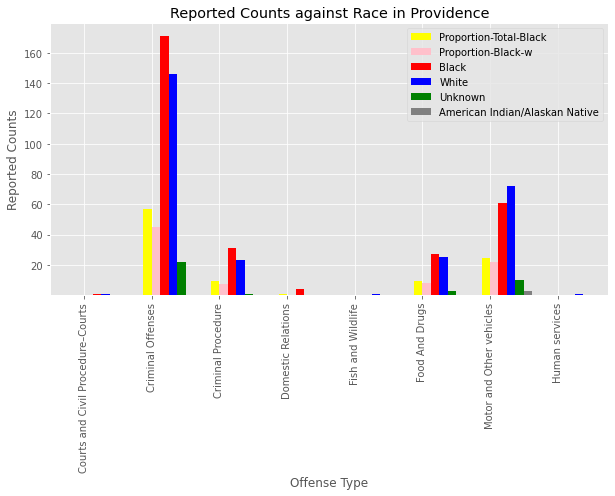

In [38]:
races = df_counts_race.iloc[:,2:].columns.tolist()
OT = df_counts_race['Description'].tolist()
dim = len(OT)
w = 1
dimw = w / dim
colors = ['yellow','pink', 'red', 'blue', 'green', 'grey']
fig, ax = plt.subplots(figsize = (10,5))
x = np.arange(len(OT))
for i in range(len(races)):
    race = races[i]
    counts = df_counts_race[races[i]].tolist()
    b = ax.bar(x + i * dimw, counts, 
               dimw, 
               bottom = 0.001, color = colors[i])
ax.set_xticks(x + dimw / 2) 
ax.set_xlabel('Offense Type')
ax.set_ylabel('Reported Counts')
x = ax.get_xticks()
legend = []

for r in races:
    legend.append(r.split('_')[1])



plt.legend(legend, loc = 'upper right')
plt.title("Reported Counts against Race in Providence")
plt.xticks(x, OT)
plt.xticks(rotation = 90)
plt.show()

### Reported Counts Adjusted for proportion

In [11]:
df_prop_counts_race = df_counts_race[['Description','counts_Total']]
df_prop_counts_race['counts_Proportion-White'] = df_prop_counts_race['counts_Total'].apply(lambda x: x * df_demographics['Percentage'][0])
df_prop_counts_race['counts_Propportion-Black'] = df_prop_counts_race['counts_Total'].apply(lambda x: x * df_demographics['Percentage'][1])

<ipython-input-11-4468f446834e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prop_counts_race['counts_Proportion-White'] = df_prop_counts_race['counts_Total'].apply(lambda x: x * df_demographics['Percentage'][0])
<ipython-input-11-4468f446834e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prop_counts_race['counts_Propportion-Black'] = df_prop_counts_race['counts_Total'].apply(lambda x: x * df_demographics['Percentage'][1])


In [12]:
df_prop_counts_race

,Description,counts_Total,counts_Proportion-White,counts_Propportion-Black
8,Courts and Civil Procedure–Courts,2.0,1.1012,0.3366
11,Criminal Offenses,339.0,186.6534,57.0537
12,Criminal Procedure,55.0,30.2830,9.2565
15,Domestic Relations,4.0,2.2024,0.6732
20,Fish and Wildlife,1.0,0.5506,0.1683
21,Food And Drugs,55.0,30.2830,9.2565
31,Motor and Other vehicles,146.0,80.3876,24.5718
40,Human services,1.0,0.5506,0.1683


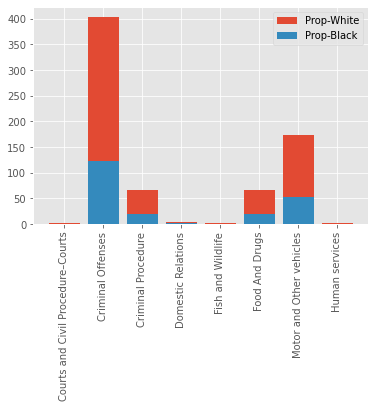

In [68]:
counts = []
legend = []
width = .8
races = df_prop_counts_race.iloc[:,2:].columns.tolist()
OT = df_prop_counts_race['Description'].tolist()
fig, ax = plt.subplots()
for i in range(len(races)):
    race = races[i]
    counts = df_prop_counts_race[race].tolist()
    ax.bar(OT, counts, width)
ticks = plt.xticks(rotation = 90)

for r in races:
    legend.append(r.split('_')[1])
    
plt.legend(legend, loc = 'upper right')

### Reported counts breaking down title into it's chapters

In [127]:
title = 'Criminal Offenses'
df_title_merged = df_merged[df_merged['Description'] == title].merge(df_chapter_title[df_chapter_title['Title_Description'] == title][['Chapter', 'Chapter_Description']], how = 'left', left_on = 'Chapter_Code', right_on = 'Chapter')

In [162]:
races = df_title_merged['Race'].unique().tolist()
races_frames = []
grouper = 'Chapter_Description'
for race in races:
    dataframe = df_title_merged[df_title_merged['Race'] == race]
    count_race = dataframe.groupby(by = grouper)['Counts'].sum().reset_index()
    count_race.rename(columns = {'Counts':'counts_%s'%race}, inplace = True)
    count_race = df_chapter_title[df_chapter_title['Title_Description'] == title]['Chapter_Description'].reset_index().merge(count_race[['Chapter_Description','counts_%s'%race]], 
                                                           how = 'left', on = 'Chapter_Description')
    count_race.drop('index', axis=1, inplace=True)
    races_frames.append(count_race)
df_counts_race = reduce(lambda left,right: pd.merge(left,right, on = ['Chapter_Description'],
                                                   how = 'outer'), races_frames)
columns = df_counts_race.iloc[:,1:].columns.tolist()
df_counts_race.dropna(axis = 0, how = 'all', subset = columns, inplace = True)
df_counts_race.drop_duplicates(inplace = True)

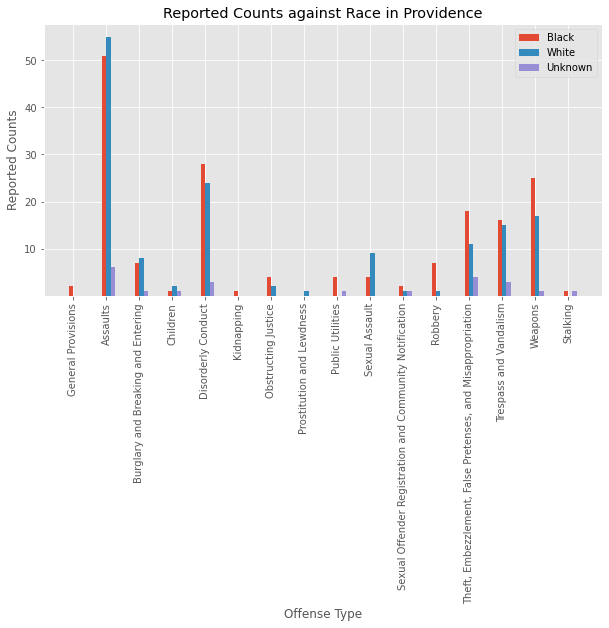

In [165]:
races = df_counts_race.iloc[:,1:].columns.tolist()
OT = df_counts_race['Chapter_Description'].tolist()
dim = len(OT)
w = 2
dimw = w / dim
  
fig, ax = plt.subplots(figsize = (10,5))
x = np.arange(len(OT))
for i in range(len(races)):
    race = races[i]
    counts = df_counts_race[races[i]].tolist()
    b = ax.bar(x + i * dimw, counts, 
               dimw, 
               bottom = 0.001)
ax.set_xticks(x + dimw / 2) 
ax.set_xlabel('Offense Type')
ax.set_ylabel('Reported Counts')
x = ax.get_xticks()
legend = []

for r in races:
    legend.append(r.split('_')[1])



plt.legend(legend, loc = 'upper right')
plt.title("Reported Counts against Race in Providence broken down by %s" % title)
plt.xticks(x, OT)
plt.xticks(rotation = 90)
plt.show()

,Chapter_Description,counts_Black,counts_White,counts_Unknown
0,General Provisions,2.0,NaN,NaN
4,Assaults,51.0,55.0,6.0
7,Burglary and Breaking and Entering,7.0,8.0,1.0
8,Children,1.0,2.0,1.0
11,Disorderly Conduct,28.0,24.0,3.0
33,Kidnapping,1.0,NaN,NaN
40,Obstructing Justice,4.0,2.0,NaN
42,Prostitution and Lewdness,NaN,1.0,NaN
44,Public Utilities,4.0,NaN,1.0
47,Sexual Assault,4.0,9.0,NaN


In [143]:
df_chapter_title[df_chapter_title['Title_Description'] == title]['Chapter_Description'].tolist()

['General Provisions',
 'Abandonment and Nonsupport',
 'Abortion',
 'Arson and Fires',
 'Assaults',
 'Bigamy and Adultery',
 'Bribery',
 'Burglary and Breaking and Entering',
 'Children',
 'Commercial Transactions',
 'Crime Against Nature',
 'Disorderly Conduct',
 'Dueling and Fighting',
 'Explosives and Fireworks',
 'False Personation',
 'Flags and Emblems',
 'Food and Beverages',
 'Forgery and Counterfeiting',
 'Fraud and False Dealing',
 'Gambling and Lotteries',
 'Graves and Corpses',
 'Hazing',
 'Highways',
 'Homicide',
 'Hotels And Public Places',
 'Jails and Prisons',
 'Kidnapping',
 'Law Practice',
 'Malfeasance and Misfeasance in Office',
 'Mayhem',
 'Nuisances',
 'Obscene and Objectionable Publications and Shows',
 'Adjudication of Obscene Publications',
 'Obstructing Justice',
 'Perjury and False Swearing',
 'Prostitution and Lewdness',
 'Commercial Sexual Activity',
 'Public Utilities',
 'Theft of Telecommunication Services',
 'Railroads and Carriers',
 'Sexual Assault',
 '

In [145]:
df_counts_race

,Chapter_Description,counts_Black,counts_White,counts_Unknown
0,General Provisions,2.0,NaN,NaN
4,Assaults,51.0,55.0,6.0
7,Burglary and Breaking and Entering,7.0,8.0,1.0
8,Children,1.0,2.0,1.0
11,Disorderly Conduct,28.0,24.0,3.0
12,Disorderly Conduct,28.0,24.0,3.0
13,Disorderly Conduct,28.0,24.0,3.0
14,Disorderly Conduct,28.0,24.0,3.0
15,Disorderly Conduct,28.0,24.0,3.0
16,Disorderly Conduct,28.0,24.0,3.0


In [132]:
df_title_merged

,Arrest Date,Year,Month,Last Name,First Name,Gender,Race,Ethnicity,Year of Birth,Age,...,Date,Time,Hour,Title_Code,Title,Description,TDescription,Chapter_Code,Chapter,Chapter_Description
0,06/06/2022 11:30:00 AM,2022,6,LUCAS,ALEANNAH,Female,Black,NonHispanic,2003,19,...,06/06/2022,11:30:00 AM,11,11,11,Criminal Offenses,Criminal Offenses,5,5,Assaults
1,06/06/2022 08:47:00 AM,2022,6,Silva,Vanessa,Female,Black,NonHispanic,1988,33,...,06/06/2022,08:47:00 AM,8,11,11,Criminal Offenses,Criminal Offenses,5,5,Assaults
2,06/06/2022 08:47:00 AM,2022,6,Silva,Vanessa,Female,Black,NonHispanic,1988,33,...,06/06/2022,08:47:00 AM,8,11,11,Criminal Offenses,Criminal Offenses,44,44,Trespass and Vandalism
3,06/06/2022 08:42:00 AM,2022,6,SIMS,JEFFREY,Male,Black,NonHispanic,1992,30,...,06/06/2022,08:42:00 AM,8,11,11,Criminal Offenses,Criminal Offenses,47,47,Weapons
4,06/06/2022 07:01:00 AM,2022,6,Melo Tejeda,Johan,Male,White,Hispanic,1984,37,...,06/06/2022,07:01:00 AM,7,11,11,Criminal Offenses,Criminal Offenses,5,5,Assaults
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,04/09/2022 01:24:00 AM,2022,4,Francisco,Sandro,Male,White,Hispanic,1981,40,...,04/09/2022,01:24:00 AM,1,11,11,Criminal Offenses,Criminal Offenses,5,5,Assaults
321,04/09/2022 12:00:00 AM,2022,4,OLIVEIRA,BENJAMIN,Male,White,NonHispanic,1977,44,...,04/09/2022,12:00:00 AM,0,11,11,Criminal Offenses,Criminal Offenses,5,5,Assaults
322,04/08/2022 07:57:00 PM,2022,4,Larios,Hector,Male,Black,Hispanic,1997,25,...,04/08/2022,07:57:00 PM,19,11,11,Criminal Offenses,Criminal Offenses,5,5,Assaults
323,04/08/2022 07:57:00 PM,2022,4,Larios,Hector,Male,Black,Hispanic,1997,25,...,04/08/2022,07:57:00 PM,19,11,11,Criminal Offenses,Criminal Offenses,26,26,Kidnapping


In [29]:
census = 'https://www.census.gov/quickfacts/providencecityrhodeisland'
p_black = .161
p_white = .532
p_asia = .056
p_native = .007



df_counts_race['counts_prop-Black'] = df_counts_race['counts_Total'].apply(lambda x: x * p_black)